In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math


In [74]:
class CosineScheduler():
    def __init__(
        self,
        lr_warmup_steps: int,
        lr: float,
        final_lr_step: int,
        final_lr_fraction: float,
    ):
        self.lr_warmup_steps = lr_warmup_steps
        self.lr = lr
        self.final_lr_step = final_lr_step
        self.final_lr_fraction = final_lr_fraction

    def get_lr(self, step: int, start_lr=None, end_lr=None):
        start_lr = start_lr if start_lr is not None else self.lr
        end_lr = end_lr if end_lr is not None else self.lr * self.final_lr_fraction

        if step < self.lr_warmup_steps:
            return start_lr * (step + 1) / self.lr_warmup_steps
        # cosine schedule that ends at final_lr_fraction * lr, then constant
        elif step < self.final_lr_step:
            return end_lr + 0.5 * (1 - end_lr/start_lr) * start_lr * (
                1
                + math.cos(
                    math.pi
                    * (step - self.lr_warmup_steps)
                    / (self.final_lr_step - self.lr_warmup_steps)
                )
            )
        else:
            return end_lr

    # had to overwrite it here, because AbstractLRScheduler doesn't know final_lr_fraction and othr params necessary for relative lr fractions
    def set_lr(self, step: int):
        
        start_lr = self.lr
        end_lr = self.lr * self.final_lr_fraction
        return self.get_lr(step, start_lr=start_lr, end_lr=end_lr)

def plot_gradient_norms(
    ax, 
    df, 
    title, 
    column='Gradient Norm', 
    normalize=True, 
    xlabel_fontsize=14, 
    tick_fontsize=12, 
    title_fontsize=16, 
    xlabel_pad=10, 
    major_grid_spacing_x=3500,  # Set spacing for major vertical gridlines
    minor_grid_spacing_x=3500,  # Set spacing for minor vertical gridlines
    major_grid_spacing_y=0.2,   # Set spacing for major horizontal gridlines (optional)
    minor_grid_spacing_y=0.2    # Set spacing for minor horizontal gridlines (optional)
):
    # Filter out the row where Step == 0
    df_filtered = df[df['Step'] != 0]

    # Extract steps and gradient norms from the filtered DataFrame
    steps = df_filtered['Step'].values
    grad_norms = df_filtered[column].values

    # Normalize if needed
    if normalize:
        grad_norms /= df_filtered[column].median()

    # Plot the data
    ax.plot(steps, grad_norms, label=column)
    
    # Set x-ticks to only show 0 and 14000
    ax.set_xticks([0, 14000])
    
    # Set custom labels for x-ticks, displaying 14000 as '14k'
    ax.set_xticklabels(['0', '14k'])
    
    # Control major and minor gridlines for the x-axis (vertical lines)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(major_grid_spacing_x))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_grid_spacing_x))

    # Control major and minor gridlines for the y-axis (horizontal lines)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(major_grid_spacing_y))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(minor_grid_spacing_y))

    # Enable grid separately for vertical and horizontal lines
    ax.grid(True, which='major', axis='x', linestyle='-', linewidth=0.5)  # Major vertical grid
    ax.grid(True, which='minor', axis='x', linestyle='-', linewidth=0.5)  # Minor vertical grid

    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)  # Major horizontal grid
    ax.grid(True, which='minor', axis='y', linestyle='-', linewidth=0.5)  # Minor horizontal grid

    # Set font sizes for labels and title
    ax.set_xlabel('Training Step', fontsize=xlabel_fontsize, labelpad=xlabel_pad)  # Control x-label distance from plot
    ax.set_title(title, fontsize=title_fontsize)
    
    # Set tick label font sizes
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

In [75]:
# Load the gradient data from CSV files
# Adjust filenames as needed
keyword = 'update'
i = 4
'/home/janek/Downloads/scaled_update_norm_encoder_blocks_block_4_block_residual_attention_layer_attention_input_projection_weight.csv'
attention_filenames = f'/home/janek/Downloads/scaled_{keyword}_norm_encoder_blocks_block_{i}_block_residual_attention_layer_attention_output_projection_weight.csv'
expert_filenames = f'/home/janek/Downloads/scaled_{keyword}_norm_encoder_blocks_block_{i}_block_residual_feedforward_layer_feedforward_expert_inner_function_lin1_weight.csv'
router_filenames = f'/home/janek/Downloads/scaled_{keyword}_norm_encoder_blocks_block_{i}_block_residual_feedforward_layer_feedforward_gating_gate.csv'
embed_filenames = f'/home/janek/Downloads/scaled_{keyword}_norm_embedding_layer_layers_0_weight.csv'
head_filenames = f'/home/janek/Downloads/scaled_{keyword}_norm_head_weight.csv'

filenames = [attention_filenames, expert_filenames, router_filenames, embed_filenames, head_filenames]

# Load CSVs and assign column names
column_names = ['Step', 'Placeholder', 'Gradient Norm']
dfs = [pd.read_csv(filename, header=None, names=column_names) for filename in filenames]

scheduler = CosineScheduler(
    lr_warmup_steps=150,
    lr=0.001,
    final_lr_fraction=0.066666,
    final_lr_step=15000
    )

for df in dfs:
    df['Normalized Gradient Norm'] = df.apply(lambda row: row['Gradient Norm'] / scheduler.set_lr(row['Step']), axis=1)


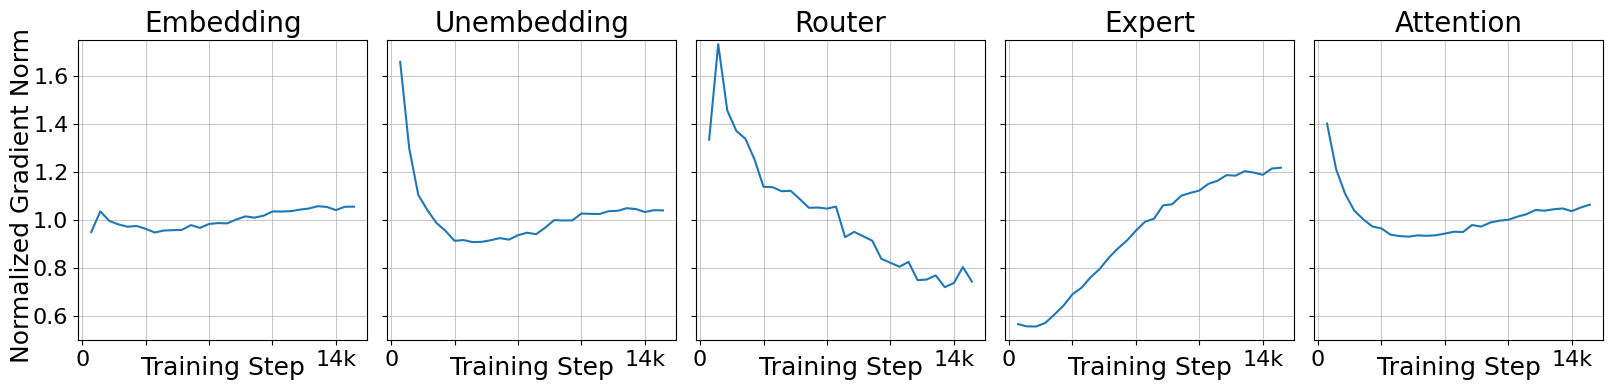

In [77]:
subplot_names = ['Embedding', 'Unembedding', 'Router', 'Expert', 'Attention']

# Create a figure with 16 subplots (8 rows and 2 columns)
fig, axes = plt.subplots(1, 5, figsize=(16, 4), sharex=True, sharey=True)

# Plot Attention gradients
for i, df in enumerate(dfs):
    plot_gradient_norms(
        axes[i],
        df,
        subplot_names[i],
        column='Normalized Gradient Norm',
        xlabel_fontsize=18,
        tick_fontsize=16,
        title_fontsize=20,
        xlabel_pad=-10
    )

fig.text(-0.005, 0.5, 'Normalized Gradient Norm', va='center', rotation='vertical', fontsize=18)
plt.ylim(0.5, 1.75)
plt.tight_layout()
# fig.suptitle(f'{keyword} scaled norms', fontsize=20)
plt.savefig('gradients.pdf', bbox_inches='tight')
plt.show()